# Evidencia 2 Implementación de una técnica de aprendizaje máquina sin el uso de un framework.
## Uso de regresion lineal

#### *Diego Alberto Baños Lopez*
#### *A01275100*



## Introducción

En este notebook se busca aplicar el concepto del algoritmo de regresion lineal con gradiente descendiente y ver como funcionan en un set de datos.
El dataset utilizado es 'IceCreamData.csv'. El cual se puede encontrar en [este enlace](https://www.kaggle.com/datasets/vinicius150987/ice-cream-revenue).


## Parte 1: Lectura de datos en CSV y caracteristicas del Dataset
Para ello se requiere que leamos los datos y los almacenemos en una variable


In [63]:
# En caso de no tener instalado alguna libreria favor de descomentar la siguiente linea de codigo
# !pip install -U pandas
# Pandas es usado para importar el CSV
import pandas as pd

# Los datos se pueden obtener de https://www.kaggle.com/datasets/vinicius150987/ice-cream-revenue
data = pd.read_csv("./IceCreamData.csv")
data

,Temperature,Revenue
0,24.566884,534.799028
1,26.005191,625.190122
2,27.790554,660.632289
3,20.595335,487.706960
4,11.503498,316.240194
...,...,...
495,22.274899,524.746364
496,32.893092,755.818399
497,12.588157,306.090719
498,22.362402,566.217304


In [64]:
# Caracteristicas del dataset
data_info = {
    "number_of_records": data.shape[0],
    "number_of_features": data.shape[1] - 1,  # Subtracting the target column
    "features": list(data.columns),
}
# Estadísticas descriptivas de cada característica
descriptive_stats = data.describe()

# Información sobre valores faltantes o nulos en el dataset
missing_values = data.isnull().sum()

# Si la columna objetivo es numérica, podemos obtener su rango de valores
# Si es categórica, podemos obtener las clases únicas y su distribución
if pd.api.types.is_numeric_dtype(data[data_info["features"][-1]]):
    target_range = (
        data[data_info["features"][-1]].min(),
        data[data_info["features"][-1]].max(),
    )
    target_info = {"type": "numeric", "range": target_range}
else:
    unique_classes = data[data_info["features"][-1]].unique()
    class_distribution = data[data_info["features"][-1]].value_counts()
    target_info = {
        "type": "categorical",
        "unique_classes": unique_classes,
        "class_distribution": class_distribution,
    }

# Agregando la información adicional al diccionario data_info
data_info["descriptive_stats"] = descriptive_stats
data_info["missing_values"] = missing_values
data_info["target_info"] = target_info

def print_data_info(data_info):
    print("Información del Dataset:\n")
    
    # Imprimir información básica
    print(f"Número de registros: {data_info['number_of_records']}")
    print(f"Número de características: {data_info['number_of_features']}")
    print(f"Características: {', '.join(data_info['features'])}\n")
    
    # Imprimir estadísticas descriptivas
    print("Estadísticas Descriptivas:")
    print(data_info['descriptive_stats'])
    print("\n")
    
    # Imprimir información sobre valores faltantes
    print("Valores Faltantes por Característica:")
    for feature, missing in data_info['missing_values'].items():
        print(f"{feature}: {missing}")
    print("\n")
    
    # Imprimir información de la columna objetivo
    print("Información de la Columna Objetivo:")
    if data_info['target_info']['type'] == 'numeric':
        print(f"Tipo: Numérico")
        print(f"Rango: {data_info['target_info']['range']}")
    else:
        print(f"Tipo: Categórico")
        print(f"Clases Únicas: {', '.join(data_info['target_info']['unique_classes'])}")
        print("Distribución de Clases:")
        for cls, count in data_info['target_info']['class_distribution'].items():
            print(f"{cls}: {count}")
    print("\n")

print_data_info(data_info)

Información del Dataset:

Número de registros: 500
Número de características: 1
Características: Temperature, Revenue

Estadísticas Descriptivas:
       Temperature      Revenue
count   500.000000   500.000000
mean     22.232225   521.570777
std       8.096388   175.404751
min       0.000000    10.000000
25%      17.122258   405.558681
50%      22.392791   529.368565
75%      27.740674   642.257922
max      45.000000  1000.000000


Valores Faltantes por Característica:
Temperature: 0
Revenue: 0


Información de la Columna Objetivo:
Tipo: Numérico
Rango: (10.0, 1000.0)




## Parte 2: Declaracion de variables iniciales

Aqui para trabajar de una forma mas sencilla empezamos a declarar las variables dependientes e independientes de nuestros datos, asi como la declaración del learning rate (alpha) y de nuestros hiperparametros iniciales. (thetas), de igual forma como estamos usando el metodo de gradiente descendiente declararemos el numero de iteraciones que se realizaran para el modelo.

In [65]:
# Variables independientes
x = data["Temperature"]
# Variables dependientes
y = data["Revenue"]
theta = [0, 0]
alpha = 0.001
num_iteraciones = 1000
# Dividiendo los datos en entrenamiento y prueba
# Mezcla tus datos
data_shuffled = data.sample(frac=1, random_state=42)

# Define el tamaño del conjunto de prueba
test_size = 0.2 # Un 20% del total del tamaño del conjunto
test_length = int(len(data) * test_size)

# Divide los datos en conjuntos de entrenamiento y prueba
test_data = data_shuffled.iloc[:test_length]
train_data = data_shuffled.iloc[test_length:]
# Asignar el tamaño del conjunto de prueba y de entrenamiento
x_train = train_data["Temperature"]
y_train = train_data["Revenue"]
x_test = test_data["Temperature"]
y_test = test_data["Revenue"]
x_train = x_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

## Parte 3: Funciones para la regresión
Aqui empezamos a declarar las funciones a utilizar en este problema, en este primer caso se requiere declarar lo siguiente
### Funcion lambda
Esta función definida como $h(x_i)=\theta_0 + \theta_1x_i$ nos ayudara a medir la relacion entre las variables a analizar, o sea estimar el valor para un dato dado $(𝑥_i)$



In [66]:
# Función lambda para la función de hipótesis
h = lambda theta, x: theta[0] + theta[1] * x

## Parte 4: Calculos e iteraciones
A partir de este punto se empezara a calcular a partir de iteraciones controladas por un ciclo for el valor de la derivada de la función de costo (Recordando que la formula de la función de costo es $J(\theta) = \frac{1}{2n} \sum_{i=1}^{n} (h_\theta(x^{(i)}) - y^{(i)})^2$), que se obtiene a partir de los datos estimados, $h_\theta(x_i)$, y reales, $y_i$:

$\frac{∂J_{θ}}{∂θ_0} = \frac{1}{n}\sum_{i=1}^{n}(h_θ(x_i)-y_i)$

$\frac{∂J_{θ}}{∂θ_1} = \frac{1}{n}\sum_{i=1}^{n}(h_θ(x_i)-y_i)x_i$

Ademas de actualizar el valor de los hiper-parámetros, recordando que $\theta_j=\theta_j-\alpha \frac{∂J_{θ}}{∂θ_j}$:

In [67]:
# Creamos una función que nos ayudará con la regresión lineal
def regresion_lineal(x, y, num_iteraciones, alpha, theta):
    """
    Parámetros:
    - x: lista de datos de entrada.
    - y: lista de datos de salida.
    - num_iteraciones: número de iteraciones para el descenso del gradiente.
    - alpha: tasa de aprendizaje.
    - theta: lista con los valores iniciales de theta.

    Retorna:
    - theta: lista con los valores actualizados de theta.
    """
    # Calcular el total de muestras a partir de los datos (n)
    n = len(x)
    
    for _ in range(num_iteraciones):
        # Calcular delta para theta0 y para cada muestra
        delta_theta0 = [h(theta, x[i]) - y[i] for i in range(n)]

        # Calcular delta para theta1 y para cada muestra
        delta_theta1 = [(h(theta, x[i]) - y[i]) * x[i] for i in range(n)]

        # Calcular sumatorias y promedio
        sum_delta_theta0 = sum(delta_theta0) / n
        sum_delta_theta1 = sum(delta_theta1) / n

        # Actualizar theta0 y theta1
        theta[0] = theta[0] - alpha * sum_delta_theta0
        theta[1] = theta[1] - alpha * sum_delta_theta1

    return theta
theta = regresion_lineal(x_train, y_train, num_iteraciones, alpha, theta)

## Parte 5: Predicciones y visualización
En esta parte y una vez realizado la regresion necesitamos ver algunas estimaciones para verificar que el modelo corre de manera correcta.

In [68]:
# Estimaciones
estimacion_12 = h(theta, 12)
estimacion_32 = h(theta, 32)

print(f"Estimación 1 (12 C): {estimacion_12} USD")
print(f"Estimación 2 (32 C): {estimacion_32} USD")


Estimación 1 (12 C): 282.1389068734599 USD
Estimación 2 (32 C): 742.1612830960079 USD


Una vez obtenido ello, observamos como se comporta el modelo realizado respecto a los datos reales con graficos

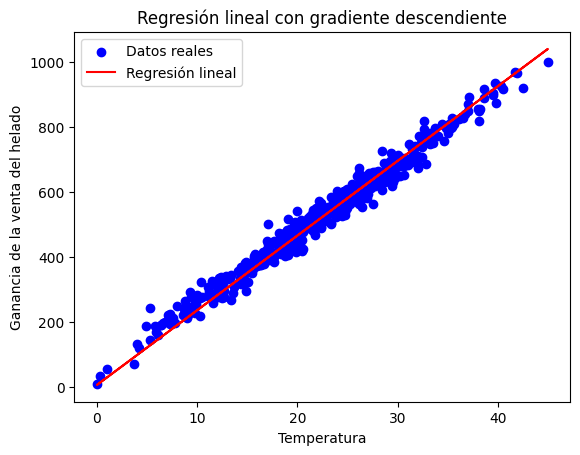

In [69]:
# Si no esta instalado matplotlib favor de descomentar esta linea de codigo:
# !pip install matplotlib

import matplotlib.pyplot as plt

# Gráfica de los datos
plt.scatter(x, y, color='blue', label='Datos reales')
# Gráfica de la regresión lineal
plt.plot(x, h(theta, x), color='red', label='Regresión lineal')
plt.xlabel('Temperatura')
plt.ylabel('Ganancia de la venta del helado')
plt.title('Regresión lineal con gradiente descendiente')
plt.legend()
plt.show()

A partir de aqui incluimos las metricas para medir el desempeño del modelo

In [70]:
# Función para calcular el Error Cuadrático Medio (MSE)
def mse(y_real, y_pred):
    return sum((y_real - y_pred) ** 2) / len(y_real)

# Predicciones para el conjunto de entrenamiento y prueba
y_train_pred = [h(theta_test, xi) for xi in x_train]
y_test_pred = [h(theta_test, xi) for xi in x_test]

# Calcular MSE para el conjunto de entrenamiento y prueba
mse_train = mse(y_train, y_train_pred)
mse_test = mse(y_test, y_test_pred)

print(f"Error Cuadrático Medio (Entrenamiento): {mse_train}")
print(f"Error Cuadrático Medio (Prueba): {mse_test}")

# Evaluar el desempeño en el conjunto de prueba
if mse_test <= mse_train:
    print("El desempeño del modelo en el conjunto de prueba es adecuado.")
else:
    print("El desempeño del modelo en el conjunto de prueba no es adecuado.")


Error Cuadrático Medio (Entrenamiento): 815.9348110530303
Error Cuadrático Medio (Prueba): 728.4228583405708
El desempeño del modelo en el conjunto de prueba es adecuado.


* El MSE de entrenamiento es 815.93. Esto significa que, en promedio, las predicciones del modelo en el conjunto de entrenamiento se desvían en  815.93 unidades (en el contexto de este problema, ingresos en dólares) del valor real.
* El MSE de prueba es 728.42, que es menor que el MSE de entrenamiento. Esto es una buena señal, ya que indica que el modelo no está sobreajustado a los datos de entrenamiento y generaliza bien a nuevos datos.
* Dado que el MSE de prueba es menor o al menos comparable al MSE de entrenamiento, se concluye que el "desempeño del modelo en el conjunto de prueba es adecuado".